In [1]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
import plotly.express as px

In [2]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

def visualize_trafic(df, center={"lat":37.6458, "lon":-122.4056}, zoom=9):
    fig = px.scatter_mapbox(df,
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phone",
                            
                            labels="phone",
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()

    
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)

def add_distance_diff(df):
    # shift(1): 上のやつが1個下に下がる → 前のデータ
    # shift(-1): 下のやつが1個上に上がる → 次のデータ
    df['latDeg_prev'] = df['latDeg'].shift(1)
    df['latDeg_next'] = df['latDeg'].shift(-1)
    df['lngDeg_prev'] = df['lngDeg'].shift(1)
    df['lngDeg_next'] = df['lngDeg'].shift(-1)
    df['phone_prev'] = df['phone'].shift(1)
    df['phone_next'] = df['phone'].shift(-1)
    
    df['latDeg_gt_prev'] = df['latDeg_gt'].shift(1)
    df['latDeg_gt_next'] = df['latDeg_gt'].shift(-1)
    df['lngDeg_gt_prev'] = df['lngDeg_gt'].shift(1)
    df['lngDeg_gt_next'] = df['lngDeg_gt'].shift(-1)
    
    df['latDeg_prev_diff'] = df['latDeg'] - df['latDeg_prev']
    df['latDeg_next_diff'] = df['latDeg_next'] - df['latDeg']
    df['latDeg_gt_prev_diff'] = df['latDeg_gt'] - df['latDeg_gt_prev']
    df['latDeg_gt_next_diff'] = df['latDeg_gt_next'] - df['latDeg_gt']
    
    df['lngDeg_prev_diff'] = df['lngDeg'] - df['lngDeg_prev']
    df['lngDeg_next_diff'] = df['lngDeg_next'] - df['lngDeg']
    df['lngDeg_gt_prev_diff'] = df['lngDeg_gt'] - df['lngDeg_gt_prev']
    df['lngDeg_gt_next_diff'] = df['lngDeg_gt_next'] - df['lngDeg_gt']
    
    df['dist_prev'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_prev'], df['lngDeg_prev'])
    df['dist_next'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_next'], df['lngDeg_next'])
    
    df['dist_gt_prev'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg_gt_prev'], df['lngDeg_gt_prev'])
    df['dist_gt_next'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg_gt_next'], df['lngDeg_gt_next'])
    
    df.loc[df['phone']!=df['phone_prev'], ['latDeg_prev', 'lngDeg_prev', 'dist_prev', 
                                           'latDeg_gt_prev', 'lngDeg_gt_prev', 'dist_gt_prev',
                                          'latDeg_prev_diff', 'latDeg_gt_prev_diff',
                                          'lngDeg_prev_diff', 'lngDeg_gt_prev_diff']] = np.nan
    
    df.loc[df['phone']!=df['phone_next'], ['latDeg_next', 'lngDeg_next', 'dist_next', 
                                           'latDeg_gt_next', 'lngDeg_gt_next', 'dist_gt_next',
                                          'latDeg_next_diff', 'latDeg_gt_next_diff',
                                          'lngDeg_next_diff', 'lngDeg_gt_next_diff']] = np.nan
    
    return df


def add_distance_nogt_diff(df):
    # shift(1): 上のやつが1個下に下がる → 前のデータ
    # shift(-1): 下のやつが1個上に上がる → 次のデータ
    df['latDeg_prev'] = df['latDeg'].shift(1)
    df['latDeg_next'] = df['latDeg'].shift(-1)
    df['lngDeg_prev'] = df['lngDeg'].shift(1)
    df['lngDeg_next'] = df['lngDeg'].shift(-1)
    df['phone_prev'] = df['phone'].shift(1)
    df['phone_next'] = df['phone'].shift(-1)
    
    df['latDeg_prev_diff'] = df['latDeg'] - df['latDeg_prev']
    df['latDeg_next_diff'] = df['latDeg_next'] - df['latDeg']
    
    df['lngDeg_prev_diff'] = df['lngDeg'] - df['lngDeg_prev']
    df['lngDeg_next_diff'] = df['lngDeg_next'] - df['lngDeg']

    
    df['dist_prev'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_prev'], df['lngDeg_prev'])
    df['dist_next'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_next'], df['lngDeg_next'])
    
    
    df.loc[df['phone']!=df['phone_prev'], ['latDeg_prev', 'lngDeg_prev', 'dist_prev', 
                                          'latDeg_prev_diff', 'lngDeg_prev_diff']] = np.nan
    
    df.loc[df['phone']!=df['phone_next'], ['latDeg_next', 'lngDeg_next', 'dist_next', 
                                           'latDeg_next_diff', 'lngDeg_next_diff']] = np.nan
    
    return df

def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

def get_train_score(df, gt):
    gt['phone'] = gt['collectionName'] + '_' + gt['phoneName']
    gt = gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
    # df = df.merge(gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    df = df.merge(gt, on=['phone', 'millisSinceGpsEpoch'], how='inner')
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    # calc_evaluate_score
    # df['phone'] = df['collectionName'] + '_' + df['phoneName']
    res = df.groupby('phone')['err'].agg([percentile50, percentile95]) # phoneによってgroupbyし、gtと予測値の差(err)の50%,95%値を求める
    res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2 
    score = res['p50_p90_mean'].mean()
    return score

def get_all_train_score(df):
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    # calc_evaluate_score
    # df['phone'] = df['collectionName'] + '_' + df['phoneName']
    res = df.groupby('phone')['err'].agg([percentile50, percentile95]) # phoneによってgroupbyし、gtと予測値の差(err)の50%,95%値を求める
    res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2 
    score = res['p50_p90_mean'].mean()
    return score

In [3]:
data_dir = Path("../input/google-smartphone-decimeter-challenge")
train_df = pd.read_csv(data_dir / "baseline_locations_train.csv")

# get all ground truth dataframe
gt_df = pd.DataFrame()
for (collection_name, phone_name), df in tqdm(train_df.groupby(["collectionName", "phoneName"])):
    path = data_dir / f"train/{collection_name}/{phone_name}/ground_truth.csv"
    df = pd.read_csv(path)  
    gt_df = pd.concat([gt_df, df]).reset_index(drop=True)   

  0%|          | 0/73 [00:00<?, ?it/s]

# Target Place

In [4]:
target_collection = '2021-04-29-US-SJC-2'
target_gt_df = gt_df[gt_df["collectionName"]==target_collection].reset_index(drop=True)
target_collection

'2021-04-29-US-SJC-2'

In [5]:
from shapely.geometry import Point
import osmnx as ox
import momepy
import geopandas as gpd
import folium

/Users/shugo/Desktop/Competitions/kaggle/outdoor/venv_outdoor/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [6]:
# change pd.DataFrame -> gpd.GeoDataFrame
target_gt_df["geometry"] = [Point(p) for p in target_gt_df[["lngDeg", "latDeg"]].to_numpy()]
target_gt_gdf = gpd.GeoDataFrame(target_gt_df, geometry=target_gt_df["geometry"])
target_gt_gdf.head(5)


,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,timeSinceFirstFixSeconds,hDop,vDop,speedMps,courseDegree,geometry
0,2021-04-29-US-SJC-2,Pixel4,1303757946435,37.334479,-121.899598,56.64,263.44,0.5,0.0,0.0,61.1,POINT (-121.89960 37.33448)
1,2021-04-29-US-SJC-2,Pixel4,1303757947435,37.334479,-121.899598,56.64,264.44,0.5,0.0,0.0,61.1,POINT (-121.89960 37.33448)
2,2021-04-29-US-SJC-2,Pixel4,1303757948435,37.334479,-121.899598,56.64,265.44,0.5,0.0,0.0,61.1,POINT (-121.89960 37.33448)
3,2021-04-29-US-SJC-2,Pixel4,1303757949435,37.334479,-121.899598,56.64,266.44,0.5,0.0,0.0,61.1,POINT (-121.89960 37.33448)
4,2021-04-29-US-SJC-2,Pixel4,1303757950435,37.334479,-121.899598,56.64,267.44,0.5,0.0,0.0,61.1,POINT (-121.89960 37.33448)


In [7]:
target_gt_gdf

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,timeSinceFirstFixSeconds,hDop,vDop,speedMps,courseDegree,geometry
0,2021-04-29-US-SJC-2,Pixel4,1303757946435,37.334479,-121.899598,56.64,263.44,0.5,0.0,0.0,61.1,POINT (-121.89960 37.33448)
1,2021-04-29-US-SJC-2,Pixel4,1303757947435,37.334479,-121.899598,56.64,264.44,0.5,0.0,0.0,61.1,POINT (-121.89960 37.33448)
2,2021-04-29-US-SJC-2,Pixel4,1303757948435,37.334479,-121.899598,56.64,265.44,0.5,0.0,0.0,61.1,POINT (-121.89960 37.33448)
3,2021-04-29-US-SJC-2,Pixel4,1303757949435,37.334479,-121.899598,56.64,266.44,0.5,0.0,0.0,61.1,POINT (-121.89960 37.33448)
4,2021-04-29-US-SJC-2,Pixel4,1303757950435,37.334479,-121.899598,56.64,267.44,0.5,0.0,0.0,61.1,POINT (-121.89960 37.33448)
...,...,...,...,...,...,...,...,...,...,...,...,...
4695,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760315000,37.334475,-121.899613,56.62,2632.00,1.1,0.0,0.0,60.0,POINT (-121.89961 37.33447)
4696,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760316000,37.334475,-121.899613,56.62,2633.00,1.1,0.0,0.0,60.0,POINT (-121.89961 37.33447)
4697,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760317000,37.334475,-121.899613,56.62,2634.00,0.9,0.0,0.0,60.0,POINT (-121.89961 37.33447)
4698,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760318000,37.334475,-121.899613,56.63,2635.00,1.0,0.0,0.0,60.0,POINT (-121.89961 37.33447)


<AxesSubplot:>

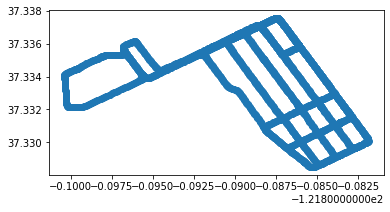

In [8]:
target_gt_gdf.plot()

In [9]:
# get road data from open street map by osmnx
offset = 0.1**5
bbox = target_gt_gdf.bounds + [-offset, -offset, offset, offset] # 境界を出力
east = bbox["minx"].min()
west = bbox["maxx"].max()
south = bbox["miny"].min()
north = bbox["maxy"].max()
G = ox.graph.graph_from_bbox(north, south, east, west, network_type='drive')

In [10]:
# ox.folium.plot_graph_folium(G)

In [11]:
# gpdのデータをノード(点)とエッジ(道路))に変換
nodes, edges = momepy.nx_to_gdf(G)

/Users/shugo/Desktop/Competitions/kaggle/outdoor/venv_outdoor/lib/python3.7/site-packages/momepy/utils.py:418: UserWarning: Approach is not set. Defaulting to 'primal'.
  warnings.warn("Approach is not set. Defaulting to 'primal'.")


In [12]:
nodes.head()

,y,x,highway,street_count,nodeID,ref,geometry
0,37.335294,-121.897948,stop,3,0,NaN,POINT (-121.89795 37.33529)
1,37.335370,-121.896596,stop,3,1,NaN,POINT (-121.89660 37.33537)
2,37.336402,-121.898691,traffic_signals,4,2,NaN,POINT (-121.89869 37.33640)
3,37.336552,-121.898785,traffic_signals,4,3,NaN,POINT (-121.89878 37.33655)
4,37.337067,-121.897707,NaN,3,4,NaN,POINT (-121.89771 37.33707)


In [13]:
edges.head()

,osmid,name,highway,oneway,length,geometry,lanes,bridge,maxspeed,ref,access,node_start,node_end
0,41932176,North Almaden Boulevard,secondary,False,120.474,"LINESTRING (-121.89795 37.33529, -121.89791 37...",NaN,NaN,NaN,NaN,NaN,0,1
1,41932176,North Almaden Boulevard,secondary,False,120.474,"LINESTRING (-121.89660 37.33537, -121.89673 37...",NaN,NaN,NaN,NaN,NaN,1,0
2,417910134,North Almaden Boulevard,secondary,True,62.399,"LINESTRING (-121.89660 37.33537, -121.89648 37...",NaN,NaN,NaN,NaN,NaN,1,111
3,417891836,West Julian Street,secondary,True,18.264,None,3,NaN,NaN,NaN,NaN,2,91
4,158245357,North Almaden Boulevard,secondary,True,139.706,"LINESTRING (-121.89869 37.33640, -121.89864 37...",1,NaN,NaN,NaN,NaN,2,0


<AxesSubplot:>

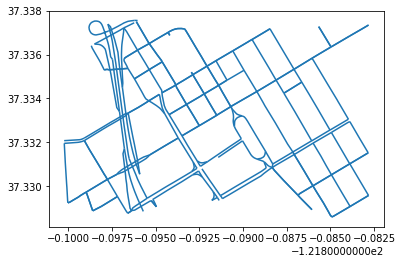

In [14]:
edges.plot()

<AxesSubplot:>

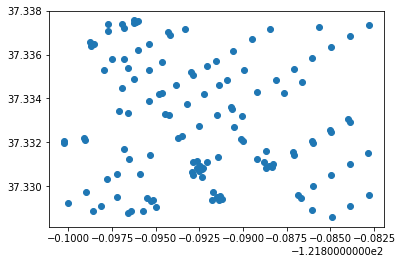

In [15]:
nodes.plot()

# only the relevent roads

In [16]:
edges = edges.dropna(subset=["geometry"]).reset_index(drop=True)
# 配列同士の重複を集合させる
hits = bbox.apply(lambda row: list(edges.sindex.intersection(row)), axis=1)
tmp = pd.DataFrame({
    # index of points table
    "pt_idx": np.repeat(hits.index, hits.apply(len)),
    # ordinal position of line - access via iloc later
    "line_i": np.concatenate(hits.values)
})
# Join back to the lines on line_i; we use reset_index() to 
# give us the ordinal position of each line
tmp = tmp.join(edges.reset_index(drop=True), on="line_i")
# Join back to the original points to get their geometry
# rename the point geometry as "point"
tmp = tmp.join(target_gt_gdf.geometry.rename("point"), on="pt_idx")
# Convert back to a GeoDataFrame, so we can do spatial ops
tmp = gpd.GeoDataFrame(tmp, geometry="geometry", crs=target_gt_gdf.crs)

In [17]:
tmp.head()

,pt_idx,line_i,osmid,name,highway,oneway,length,geometry,lanes,bridge,maxspeed,ref,access,node_start,node_end,point
0,45,178.0,"[28357376, 395452213, 184867253, 946401467, 28...",NaN,motorway_link,True,388.907,"LINESTRING (-121.89851 37.33648, -121.89827 37...","[1, 2]",yes,NaN,NaN,NaN,91,49,POINT (-121.89847 37.33505)
1,46,178.0,"[28357376, 395452213, 184867253, 946401467, 28...",NaN,motorway_link,True,388.907,"LINESTRING (-121.89851 37.33648, -121.89827 37...","[1, 2]",yes,NaN,NaN,NaN,91,49,POINT (-121.89837 37.33509)
2,47,178.0,"[28357376, 395452213, 184867253, 946401467, 28...",NaN,motorway_link,True,388.907,"LINESTRING (-121.89851 37.33648, -121.89827 37...","[1, 2]",yes,NaN,NaN,NaN,91,49,POINT (-121.89827 37.33514)
3,48,178.0,"[28357376, 395452213, 184867253, 946401467, 28...",NaN,motorway_link,True,388.907,"LINESTRING (-121.89851 37.33648, -121.89827 37...","[1, 2]",yes,NaN,NaN,NaN,91,49,POINT (-121.89819 37.33517)
4,49,178.0,"[28357376, 395452213, 184867253, 946401467, 28...",NaN,motorway_link,True,388.907,"LINESTRING (-121.89851 37.33648, -121.89827 37...","[1, 2]",yes,NaN,NaN,NaN,91,49,POINT (-121.89813 37.33520)


# Find closest road

In [18]:
a = tmp.geometry.distance(gpd.GeoSeries(tmp.point))

ipykernel_launcher:1: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

ipykernel_launcher:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None



In [19]:
tmp1 = tmp.copy()
tmp1["snap_dist"] = tmp1.geometry.distance(gpd.GeoSeries(tmp1.point))

# Discard any lines that are greater than tolerance from points
tolerance = 0.00005
tmp1 = tmp1.loc[tmp1.snap_dist <= tolerance]
# Sort on ascending snap distance, so that closest goes to top
tmp1 = tmp1.sort_values(by=["snap_dist"])

# group by the index of the points and take the first, which is the
# closest line 
closest = tmp1.groupby("pt_idx").first()
# construct a GeoDataFrame of the closest lines
closest = gpd.GeoDataFrame(closest, geometry="geometry")
closest = closest.drop_duplicates("line_i").reset_index(drop=True)

ipykernel_launcher:2: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

ipykernel_launcher:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None



<AxesSubplot:>

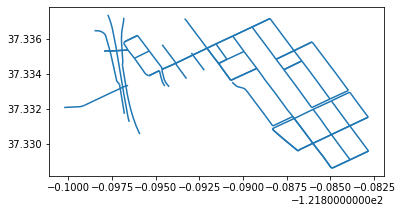

In [20]:
closest.plot()

In [21]:
closest

,line_i,osmid,name,highway,oneway,length,geometry,lanes,bridge,maxspeed,ref,access,node_start,node_end,point,snap_dist
0,0.0,41932176,North Almaden Boulevard,secondary,False,120.474,"LINESTRING (-121.89795 37.33529, -121.89791 37...",None,None,None,None,None,0,1,POINT (-121.89791 37.33529),1.391657e-05
1,1.0,41932176,North Almaden Boulevard,secondary,False,120.474,"LINESTRING (-121.89660 37.33537, -121.89673 37...",None,None,None,None,None,1,0,POINT (-121.89783 37.33530),1.437807e-05
2,178.0,"[28357376, 395452213, 184867253, 946401467, 28...",North Almaden Boulevard,motorway_link,True,388.907,"LINESTRING (-121.89851 37.33648, -121.89827 37...","[1, 2]",yes,None,None,None,91,49,POINT (-121.89763 37.33529),1.142748e-05
3,58.0,"[28357317, 28357351, 28357352, 157782059, 2835...",Guadalupe Freeway,motorway,True,690.498,"LINESTRING (-121.89652 37.33125, -121.89657 37...",3,yes,65 mph,CA 87,None,28,51,POINT (-121.89723 37.33531),1.277780e-05
4,2.0,417910134,North Almaden Boulevard,secondary,True,62.399,"LINESTRING (-121.89660 37.33537, -121.89648 37...",None,None,None,None,None,1,111,POINT (-121.89656 37.33528),3.135938e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,20.0,32863839,Post Street,residential,False,50.336,"LINESTRING (-121.89092 37.33483, -121.89096 37...",None,None,None,None,None,11,37,POINT (-121.89137 37.33462),1.271697e-06
97,10.0,"[416909272, 680787590]",East San Fernando Street,secondary,False,106.079,"LINESTRING (-121.88811 37.33484, -121.88805 37...",2,None,None,None,None,6,32,POINT (-121.88810 37.33484),8.236188e-07
98,57.0,157782382,West San Carlos Street,tertiary,True,118.154,"LINESTRING (-121.88715 37.33156, -121.88722 37...",2,None,25 mph,None,None,27,77,POINT (-121.88719 37.33154),5.058862e-06
99,65.0,"[680787592, 680787593, 680787594]",West San Fernando Street,secondary,False,152.371,"LINESTRING (-121.88921 37.33431, -121.88929 37...","[3, 2]",None,25 mph,None,None,31,39,POINT (-121.88924 37.33427),3.359779e-05


In [22]:
closest.shape

(101, 16)

# Generate road points

In [23]:
line_points_list = []
split = 50  # param: number of split in each LineString
for dist in range(0, split, 1):
    dist = dist/split
    line_points = closest["geometry"].interpolate(dist, normalized=True)
    line_points_list.append(line_points)
line_points = pd.concat(line_points_list).reset_index(drop=True)
line_points = line_points.reset_index().rename(columns={0:"geometry"})
line_points["lngDeg"] = line_points["geometry"].x
line_points["latDeg"] = line_points["geometry"].y

In [24]:
fig = px.scatter_mapbox(line_points,

                    # Here, plotly gets, (x,y) coordinates
                    lat="latDeg",
                    lon="lngDeg",

                    zoom=15,
                    center={"lat":37.33351, "lon":-121.8906},
                    height=600,
                    width=800)
fig.update_layout(mapbox_style='stamen-terrain')
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.update_layout(title_text="GPS trafic")
fig.show()

In [25]:
line_points

,index,geometry,lngDeg,latDeg
0,0,POINT (-121.89795 37.33529),-121.897948,37.335294
1,1,POINT (-121.89660 37.33537),-121.896596,37.335370
2,2,POINT (-121.89851 37.33648),-121.898508,37.336478
3,3,POINT (-121.89652 37.33125),-121.896522,37.331255
4,4,POINT (-121.89660 37.33537),-121.896596,37.335370
...,...,...,...,...
5045,5045,POINT (-121.89140 37.33460),-121.891397,37.334603
5046,5046,POINT (-121.88711 37.33532),-121.887106,37.335319
5047,5047,POINT (-121.88828 37.33103),-121.888280,37.331029
5048,5048,POINT (-121.89068 37.33364),-121.890676,37.333642


In [26]:
target_collection = '2021-04-29-US-SJC-2'
train['collectionName'] = train['phone'].apply(lambda x: x.split('_')[0])
train['phoneName'] = train['phone'].apply(lambda x: x.split('_')[0])
train1 = train[train["collectionName"]==target_collection].reset_index(drop=True)
train1

NameError: name 'train' is not defined

In [27]:
train1[['latDeg','lngDeg']].iloc[0]

NameError: name 'train1' is not defined

In [ ]:
b = pd.DataFrame(np.repeat(train1[['latDeg','lngDeg']].iloc[0],len(line_points)),
                
                # columns=['latDeg','lngDeg']
                )
# pd.merge(b, line_points[['latDeg', 'lngDeg']])
b

In [ ]:
pd.DataFrame(np.repeat(train1['latDeg'][0],len(line_points)), line_points['latDeg'],
            columns=['latDeg', 'latDeg_sp'])

In [ ]:
calc_haversine(line_points['latDeg'], line_points['lngDeg'],
                train['latDeg'], train['lngDeg'])

# apply snap to grid

In [ ]:
import pathlib
INPUT = '../input/google-smartphone-decimeter-challenge'

# filtered_train = pd.read_csv(INPUT + '/' + 'baseline_locations_filtered_train.csv')
train = pd.read_csv('../output/filtered_nb041.csv')
test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')

# ground truth
p = pathlib.Path(INPUT)
gt_files = list(p.glob('train/*/*/ground_truth.csv'))

gts = []
for gt_file in gt_files:
    gts.append(pd.read_csv(gt_file))
ground_truth = pd.concat(gts)

In [ ]:
train

In [ ]:
def snap_to_grid(df, threshold):
    """
    Snap to grid if within a threshold.

    input:
        dataframe: train or test
    ouput:
        dataframe applyed snap to grid
    
    latDeg, lngDeg are the predicted points.
    latDeg_, lngDeg_ are the closest grid points.
    _latDeg_, _lngDeg_ are the new predictions after post processing.
    """
    df['_latDeg_'] = df['latDeg']
    df['_lngDeg_'] = df['lngDeg']
    df.loc[df['dist'] < threshold, '_latDeg_'] = df.loc[df['dist'] < threshold]['latDeg_']
    df.loc[df['dist'] < threshold, '_lngDeg_'] = df.loc[df['dist'] < threshold]['lngDeg_']

    return df.copy()

# Calculate the distances
train['dist'] = calc_haversine(train['latDeg_'], train['lngDeg_'], 
                                train['latDeg'], train['lngDeg'])
# sub['dist'] = np.sqrt( (sub.x-sub.x_)**2 + (sub.y-sub.y_)**2 )

# sub_pp = snap_to_grid(sub, threshold=5)

# sub_pp = sub_pp[['site_path_timestamp','floor','_x_','_y_','site','path','floorNo']] \
#     .rename(columns={'_x_':'x', '_y_':'y'})

In [ ]:
get_train_score(train, ground_truth)